# SPARQL bei Europeana


Auch Europeana bietet einen SPARQL-Zugriff. Die Dokumentation ist [hier](https://europeana.atlassian.net/wiki/spaces/EF/pages/2385870903/SPARQL+API+Documentation#Getting-Started).



In [1]:
import requests
import json

In [2]:
ENDPOINT = "https://sparql.europeana.eu/"

In [42]:
europeana_query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
SELECT ?title ?creator ?mediaURL ?date
WHERE {
  ?item edm:type "SOUND" ;
      ore:proxyIn ?proxy;
      dc:title ?title ;
      dc:creator ?creator ;
      dc:date ?date .
  ?proxy edm:isShownBy ?mediaURL .
  
  }
LIMIT 10
"""

In [40]:
europeana_query_with_rights = """
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>

SELECT (COUNT(*) AS ?count)
WHERE {
  {
    ?agg a ?t ; edm:type "SOUND" ; (edm:rights|dc:rights) ?rights .
    FILTER(?t IN (ore:Aggregation, edm:EuropeanaAggregation))
    BIND("agg" AS ?where)
  } UNION {
    ?agg a ?t ; edm:type "SOUND" ; (edm:isShownBy|edm:hasView) ?wr .
    FILTER(?t IN (ore:Aggregation, edm:EuropeanaAggregation))
    ?wr (edm:rights|dc:rights) ?rights .
    BIND("webres" AS ?where)
  }
}
GROUP BY ?where ?rights
ORDER BY DESC(?count)
LIMIT 20
"""

In [43]:
params = {
    "query": europeana_query,
    "format": "json"
}

try:
    response = requests.get(ENDPOINT, params=params)
    
    
    response.raise_for_status() 
    results = response.json()

    print(json.dumps(results, indent=2, ensure_ascii=False))
    
except requests.exceptions.RequestException as e:
    print(f"Da ist ein Fehler!: {e}")


{
  "head": {
    "link": [],
    "vars": [
      "title",
      "creator",
      "mediaURL",
      "date"
    ]
  },
  "results": {
    "distinct": false,
    "ordered": true,
    "bindings": [
      {
        "title": {
          "type": "literal",
          "value": "Hora medura"
        },
        "creator": {
          "type": "literal",
          "value": "Prague Klezmerim [instrumentalist]"
        },
        "mediaURL": {
          "type": "uri",
          "value": "http://mediatheque.cfmj.fr/audio/extrait/CD_S004/CD_404_18_EX.mp3"
        },
        "date": {
          "type": "literal",
          "value": "2008"
        }
      },
      {
        "title": {
          "type": "literal",
          "value": "Mechol halachat"
        },
        "creator": {
          "type": "literal",
          "value": "Prague Klezmerim [instrumentalist]"
        },
        "mediaURL": {
          "type": "uri",
          "value": "http://mediatheque.cfmj.fr/audio/extrait/CD_S004/CD_404_22_EX.m

In [44]:
items = results["results"]["bindings"]

for i in items:
    print(f"""Title: {i['title']['value']}
            Creator: {i['creator']['value']}
            Date: {i['date']['value']}
            URL: {i['mediaURL']['value']}""")

Title: Hora medura
            Creator: Prague Klezmerim [instrumentalist]
            Date: 2008
            URL: http://mediatheque.cfmj.fr/audio/extrait/CD_S004/CD_404_18_EX.mp3
Title: Mechol halachat
            Creator: Prague Klezmerim [instrumentalist]
            Date: 2008
            URL: http://mediatheque.cfmj.fr/audio/extrait/CD_S004/CD_404_22_EX.mp3
Title: שני שושנים
            Creator: Gaon, Yehoram [singer]
            Date: 1976
            URL: http://mediatheque.cfmj.fr/audio/extrait/D33-30_S008/D33-30_833_05_EX.mp3
Title: ברית עולם
            Creator: כספי, מתי [singer]
            Date: 1983
            URL: http://mediatheque.cfmj.fr/audio/extrait/D33-30_S008/D33-30_808_10_EX.mp3
Title: לפעמים
            Creator: ברטי, שלוה [singer]
            Date: 1988
            URL: http://mediatheque.cfmj.fr/audio/extrait/D33-30_S008/D33-30_826_02_EX.mp3
Title: A gleyzele yash
            Creator: Ruff, Astrid [singer]
            Date: 2006
            URL: http://media

In [45]:
import io
import librosa

url = items[0]["mediaURL"]["value"]


response = requests.get(url, allow_redirects=True)
response.raise_for_status()


with io.BytesIO(response.content) as bio:
    y, sr = librosa.load(bio, sr=None, mono=True) 

print(f"✅ Loaded directly from memory: {len(y)} samples @ {sr} Hz")
print(f"🕒 Duration: {librosa.get_duration(y=y, sr=sr):.2f} sec")


✅ Loaded directly from memory: 1323001 samples @ 44100 Hz
🕒 Duration: 30.00 sec


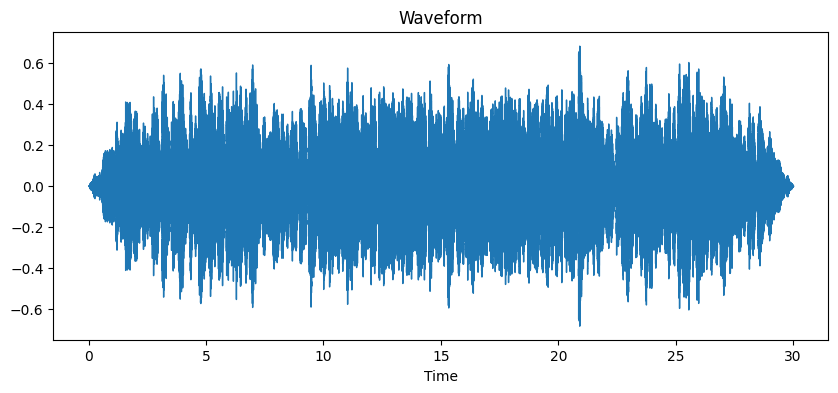

In [46]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.show()

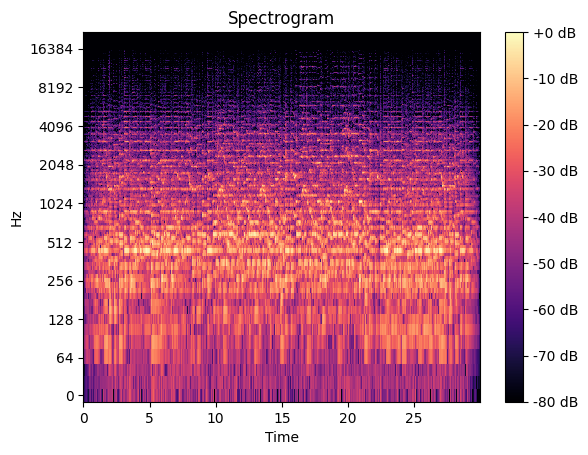

In [47]:
import numpy as np
spec = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.show()

In [51]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

if isinstance(tempo, (list, np.ndarray)):
    tempo_value = tempo.item(0) if hasattr(tempo, "item") else tempo[0]
else:
    tempo_value = float(tempo)

print(f"🎶 Estimated tempo: {tempo_value:.1f} BPM")



🎶 Estimated tempo: 152.0 BPM
